# Level 1 Submission for Open Science Data Challenge 2023
Done by Josiah Teh & Pai Hwai from James Cook University Singapore

## Data Development and Preparation 

### Load CSV

In [1]:
import pandas as pd
import numpy as np

In [2]:
crop_data = pd.read_csv("Crop_Location_Data_20221201.csv")
crop_data.head()

,Latitude and Longitude,Class of Land
0,"(10.323727047081501, 105.2516346045924)",Rice
1,"(10.322364360592521, 105.27843410554115)",Rice
2,"(10.321455902933202, 105.25254306225168)",Rice
3,"(10.324181275911162, 105.25118037576274)",Rice
4,"(10.324635504740822, 105.27389181724476)",Rice


In [3]:
print(f"Shape of Crop Data: {crop_data.shape}") 

Shape of Crop Data: (600, 2)


In [4]:
crop_data.describe()

,Latitude and Longitude,Class of Land
count,600,600
unique,600,2
top,"(10.323727047081501, 105.2516346045924)",Rice
freq,1,300


### Load Sentinel Data

In [5]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')
import os

# Import common GIS tools
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio.features

# Import Planetary Computer tools
import stackstac
import pystac_client
import planetary_computer as pc
import xrspatial.multispectral as ms
import odc
from odc.stac import stac_load

from tqdm import tqdm
tqdm.pandas()

# API key
pc.settings.set_subscription_key('1ef143ba7595457ebff1a921151a9918')

In [6]:
def get_sentinel_data(latlong):
    """ Returns a list of VV,VH, VV/VH values for a given latitude and longitude. """
    
    bands_of_interest = ['vh','vv']
    time_window="2021-11-01/2022-08-31"
    box_size_deg = 0.0004 # Roughly a 5x5 box
    
    latlong = latlong.replace('(','').replace(')','').replace(' ','').split(',')
    bbox_of_interest = (float(latlong[1])-box_size_deg/2 , float(latlong[0])-box_size_deg/2, 
                        float(latlong[1])+box_size_deg/2, float(latlong[0])+box_size_deg/2)
    
    vv_list = []
    vh_list = []
    vv_by_vh_list = []
    
    catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
    search = catalog.search(collections=["sentinel-1-rtc"], bbox=bbox_of_interest, datetime=time_window)
    items = list(search.get_all_items())
    item = items[0]
    items.reverse()
    
    data = stac_load([items[1]],bands=bands_of_interest, patch_url=pc.sign, bbox=bbox_of_interest).isel(time=0)

    for item in items:
        data = stac_load([item], bands=bands_of_interest, patch_url=pc.sign, bbox=bbox_of_interest).isel(time=0)
        if(data['vh'].values[0][0]!=-32768.0 and data['vv'].values[0][0]!=-32768.0):
            data = data.where(~data.isnull(), 0)
            vh = data["vh"].astype("float64")
            vv = data["vv"].astype("float64")
            vv_list.append(np.median(vv))
            vh_list.append(np.median(vh))
            vv_by_vh_list.append(np.median(vv)/np.median(vh))
              
    return vv_list, vh_list, vv_by_vh_list

In [7]:
train_band_values=crop_data.progress_apply(lambda x: get_sentinel_data(x["Latitude and Longitude"]), axis=1)
vh = [x[0] for x in train_band_values]
vv = [x[1] for x in train_band_values]
vv_by_vh = [x[2] for x in train_band_values]
vh_vv_data = pd.DataFrame(list(zip(vh,vv,vv_by_vh)),columns = ["vv_list","vh_list","vv/vh_list"])

100%|██████████| 600/600 [1:50:03<00:00, 11.01s/it]


In [ ]:
vh_vv_data

In [ ]:
for col in vh_vv_data.columns:
    vh_vv_data[col] = vh_vv_data[col].apply(lambda x: np.array(x))

In [21]:
type(vh_vv_data["vv_list"].iloc[0])

numpy.ndarray

In [26]:
rvi = (vh_vv_data["vv_list"] / (vh_vv_data["vv_list"] + vh_vv_data["vh_list"]))
rvi

0      [0.6770013443829713, 0.7650207626328163, 0.764...
1      [0.7603722278367199, 0.8699584958387813, 0.724...
2      [0.6809153737878286, 0.7182062469512054, 0.642...
3      [0.7392245239578717, 0.7563370627960891, 0.675...
4      [0.7793639479268326, 0.7580063304279673, 0.718...
                             ...                        
595    [0.8447714563137138, 0.7665128814874204, 0.762...
596    [0.8134861758083533, 0.7333147680724563, 0.830...
597    [0.7485313994319769, 0.729718541099053, 0.8171...
598    [0.8561544131010158, 0.7769415341478552, 0.815...
599    [0.8358219299271932, 0.7721834161367874, 0.834...
Length: 600, dtype: object

In [27]:
vh_vv_data["rvi"] = rvi
vh_vv_data

,vv_list,vh_list,vv/vh_list,rvi
0,"[0.07633522897958755, 0.1055772714316845, 0.12...","[0.03641968593001366, 0.03242848813533783, 0.0...","[2.0959881182467663, 3.2556951465349164, 3.246...","[0.6770013443829713, 0.7650207626328163, 0.764..."
1,"[0.07775161415338516, 0.21660436689853668, 0.1...","[0.024503059685230255, 0.032378047704696655, 0...","[3.1731389937498955, 6.689852608596804, 2.6265...","[0.7603722278367199, 0.8699584958387813, 0.724..."
2,"[0.07909337431192398, 0.0808926373720169, 0.07...","[0.037064047530293465, 0.031738849356770515, 0...","[2.133964841462034, 2.548694707319657, 1.79720...","[0.6809153737878286, 0.7182062469512054, 0.642..."
3,"[0.09969594702124596, 0.09643841162323952, 0.0...","[0.03516963683068752, 0.031068775802850723, 0....","[2.834716420337202, 3.1040299828740205, 2.0851...","[0.7392245239578717, 0.7563370627960891, 0.675..."
4,"[0.061404578387737274, 0.0796160064637661, 0.0...","[0.01738348789513111, 0.02541742566972971, 0.0...","[3.532350858364615, 3.1323395019733615, 2.5508...","[0.7793639479268326, 0.7580063304279673, 0.718..."
...,...,...,...,...
595,"[0.4515400826931, 0.29349878430366516, 0.18908...","[0.08297144621610641, 0.08940252289175987, 0.0...","[5.442114164396076, 3.2828915203993265, 3.2164...","[0.8447714563137138, 0.7665128814874204, 0.762..."
596,"[0.3343413472175598, 0.2766057103872299, 0.299...","[0.07665684446692467, 0.1005934439599514, 0.06...","[4.361532874756135, 2.749738944193551, 4.89913...","[0.8134861758083533, 0.7333147680724563, 0.830..."
597,"[0.23833606392145157, 0.24556903541088104, 0.2...","[0.08006883412599564, 0.09095665439963341, 0.0...","[2.976639619185762, 2.6998468339867916, 4.4684...","[0.7485313994319769, 0.729718541099053, 0.8171..."
598,"[0.4367031306028366, 0.3260190486907959, 0.255...","[0.07337206602096558, 0.09359946101903915, 0.0...","[5.951899057579374, 3.4831295516165426, 4.4246...","[0.8561544131010158, 0.7769415341478552, 0.815..."


In [7]:
def generate_stastical_features(dataframe):
    '''
    Returns a  list of statistical features such as min,max,range,mean for each of the features
    Attributes:
    dataframe - DataFrame consisting of VV,VH and VV/VH 
    '''
    features_list = []
    for index, row in dataframe.iterrows():
        min_vv = min(row[0])
        max_vv = max(row[0])
        range_vv = max_vv - min_vv
        mean_vv = np.mean(row[0])
    
        min_vh = min(row[1])
        max_vh = max(row[1])
        range_vh = max_vh - min_vh
        mean_vh = np.mean(row[1])
        
        min_vv_by_vh = min(row[2])
        max_vv_by_vh = max(row[2])
        range_vv_by_vh = max_vv_by_vh - min_vv_by_vh
        mean_vv_by_vh = np.mean(row[2])
        
        min_rvi = min(row[3])
        max_rvi = max(row[3])
        range_rvi = max_rvi - min_rvi
        mean_rvi = np.mean(row[3])
    
        features_list.append([min_vv, max_vv, range_vv, mean_vv, min_vh, max_vh, range_vh,  mean_vh, 
                          min_vv_by_vh,  max_vv_by_vh, range_vv_by_vh, mean_vv_by_vh, min_rvi, max_rvi, range_rvi, mean_rvi])
    return features_list

In [29]:
features = generate_stastical_features(vh_vv_data)
features_data = pd.DataFrame(features ,columns = ['min_vv', 'max_vv', 'range_vv', 'mean_vv', 'min_vh', 'max_vh', 'range_vh', 'mean_vh', 
                          'min_vv_by_vh',  'max_vv_by_vh', 'range_vv_by_vh', 'mean_vv_by_vh', 'min_rvi', 'max_rvi', 'range_rvi', 'mean_rvi'] )

In [30]:
features_data

,min_vv,max_vv,range_vv,mean_vv,min_vh,max_vh,range_vh,mean_vh,min_vv_by_vh,max_vv_by_vh,range_vv_by_vh,mean_vv_by_vh,min_rvi,max_rvi,range_rvi,mean_rvi
0,0.022274,0.269761,0.247487,0.116468,0.003141,0.078778,0.075636,0.025373,1.368121,32.547485,31.179365,6.357204,0.577724,0.970192,0.392467,0.803408
1,0.013224,0.491939,0.478715,0.135152,0.003354,0.090849,0.087496,0.026800,1.309096,42.842220,41.533124,6.712027,0.566930,0.977191,0.410261,0.802753
2,0.016693,0.548456,0.531762,0.109102,0.003337,0.073560,0.070223,0.024353,1.452944,31.994109,30.541165,6.158365,0.592327,0.969692,0.377365,0.784624
3,0.015995,0.478505,0.462510,0.126329,0.003879,0.052779,0.048900,0.024346,1.495237,35.901330,34.406093,7.448409,0.599237,0.972901,0.373664,0.813644
4,0.014075,0.487998,0.473923,0.129143,0.004487,0.096872,0.092384,0.025944,1.574984,45.480071,43.905087,7.384482,0.611648,0.978485,0.366837,0.800147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.145322,0.556387,0.411064,0.287192,0.033406,0.112107,0.078701,0.064786,2.603283,7.320887,4.717604,4.483530,0.722475,0.879821,0.157345,0.809555
596,0.159897,0.413889,0.253993,0.261459,0.039730,0.114915,0.075185,0.069592,2.404603,7.025597,4.620995,3.924344,0.706280,0.875399,0.169119,0.787326
597,0.171829,0.437881,0.266052,0.262192,0.038087,0.094669,0.056582,0.063881,2.055453,6.657506,4.602054,4.231725,0.672716,0.869409,0.196693,0.800927
598,0.209815,0.474909,0.265094,0.287283,0.047271,0.108973,0.061702,0.069803,2.841932,6.769919,3.927987,4.202889,0.739714,0.871299,0.131584,0.802535


In [37]:
# Join features to original dataframe
crop_data_final = pd.concat([crop_data, features_data], axis=1)
crop_data_final

,Latitude and Longitude,Class of Land,min_vv,max_vv,range_vv,mean_vv,min_vh,max_vh,range_vh,mean_vh,min_vv_by_vh,max_vv_by_vh,range_vv_by_vh,mean_vv_by_vh,min_rvi,max_rvi,range_rvi,mean_rvi
0,"(10.323727047081501, 105.2516346045924)",Rice,0.022274,0.269761,0.247487,0.116468,0.003141,0.078778,0.075636,0.025373,1.368121,32.547485,31.179365,6.357204,0.577724,0.970192,0.392467,0.803408
1,"(10.322364360592521, 105.27843410554115)",Rice,0.013224,0.491939,0.478715,0.135152,0.003354,0.090849,0.087496,0.026800,1.309096,42.842220,41.533124,6.712027,0.566930,0.977191,0.410261,0.802753
2,"(10.321455902933202, 105.25254306225168)",Rice,0.016693,0.548456,0.531762,0.109102,0.003337,0.073560,0.070223,0.024353,1.452944,31.994109,30.541165,6.158365,0.592327,0.969692,0.377365,0.784624
3,"(10.324181275911162, 105.25118037576274)",Rice,0.015995,0.478505,0.462510,0.126329,0.003879,0.052779,0.048900,0.024346,1.495237,35.901330,34.406093,7.448409,0.599237,0.972901,0.373664,0.813644
4,"(10.324635504740822, 105.27389181724476)",Rice,0.014075,0.487998,0.473923,0.129143,0.004487,0.096872,0.092384,0.025944,1.574984,45.480071,43.905087,7.384482,0.611648,0.978485,0.366837,0.800147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,"(10.013942985253381, 105.67361318732796)",Non Rice,0.145322,0.556387,0.411064,0.287192,0.033406,0.112107,0.078701,0.064786,2.603283,7.320887,4.717604,4.483530,0.722475,0.879821,0.157345,0.809555
596,"(10.01348875642372, 105.67361318732796)",Non Rice,0.159897,0.413889,0.253993,0.261459,0.039730,0.114915,0.075185,0.069592,2.404603,7.025597,4.620995,3.924344,0.706280,0.875399,0.169119,0.787326
597,"(10.013034527594062, 105.67361318732796)",Non Rice,0.171829,0.437881,0.266052,0.262192,0.038087,0.094669,0.056582,0.063881,2.055453,6.657506,4.602054,4.231725,0.672716,0.869409,0.196693,0.800927
598,"(10.012580298764401, 105.67361318732796)",Non Rice,0.209815,0.474909,0.265094,0.287283,0.047271,0.108973,0.061702,0.069803,2.841932,6.769919,3.927987,4.202889,0.739714,0.871299,0.131584,0.802535


In [33]:
# scrap dataframe to csv 
# import csv
# crop_data_final.to_csv('crop_data_final.csv') 

In [8]:
crop_data_final = pd.read_csv("crop_data_final.csv")
crop_data_final = crop_data_final[crop_data_final.columns[1:]]
crop_data_final

,Latitude and Longitude,Class of Land,min_vv,max_vv,range_vv,mean_vv,min_vh,max_vh,range_vh,mean_vh,min_vv_by_vh,max_vv_by_vh,range_vv_by_vh,mean_vv_by_vh,min_rvi,max_rvi,range_rvi,mean_rvi
0,"(10.323727047081501, 105.2516346045924)",Rice,0.022274,0.269761,0.247487,0.116468,0.003141,0.078778,0.075636,0.025373,1.368121,32.547485,31.179365,6.357204,0.577724,0.970192,0.392467,0.803408
1,"(10.322364360592521, 105.27843410554115)",Rice,0.013224,0.491939,0.478715,0.135152,0.003354,0.090849,0.087496,0.026800,1.309096,42.842220,41.533124,6.712027,0.566930,0.977191,0.410261,0.802753
2,"(10.321455902933202, 105.25254306225168)",Rice,0.016693,0.548456,0.531762,0.109102,0.003337,0.073560,0.070223,0.024353,1.452944,31.994109,30.541165,6.158365,0.592327,0.969692,0.377365,0.784624
3,"(10.324181275911162, 105.25118037576274)",Rice,0.015995,0.478505,0.462510,0.126329,0.003879,0.052779,0.048900,0.024346,1.495237,35.901330,34.406093,7.448409,0.599237,0.972901,0.373664,0.813644
4,"(10.324635504740822, 105.27389181724476)",Rice,0.014075,0.487998,0.473923,0.129143,0.004487,0.096872,0.092384,0.025944,1.574984,45.480071,43.905087,7.384482,0.611648,0.978485,0.366837,0.800147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,"(10.013942985253381, 105.67361318732796)",Non Rice,0.145322,0.556387,0.411064,0.287192,0.033406,0.112107,0.078701,0.064786,2.603283,7.320887,4.717604,4.483530,0.722475,0.879821,0.157345,0.809555
596,"(10.01348875642372, 105.67361318732796)",Non Rice,0.159897,0.413889,0.253993,0.261459,0.039730,0.114915,0.075185,0.069592,2.404603,7.025597,4.620995,3.924344,0.706280,0.875399,0.169119,0.787326
597,"(10.013034527594062, 105.67361318732796)",Non Rice,0.171829,0.437881,0.266052,0.262192,0.038087,0.094669,0.056582,0.063881,2.055453,6.657506,4.602054,4.231725,0.672716,0.869409,0.196693,0.800927
598,"(10.012580298764401, 105.67361318732796)",Non Rice,0.209815,0.474909,0.265094,0.287283,0.047271,0.108973,0.061702,0.069803,2.841932,6.769919,3.927987,4.202889,0.739714,0.871299,0.131584,0.802535


### Data Analysis

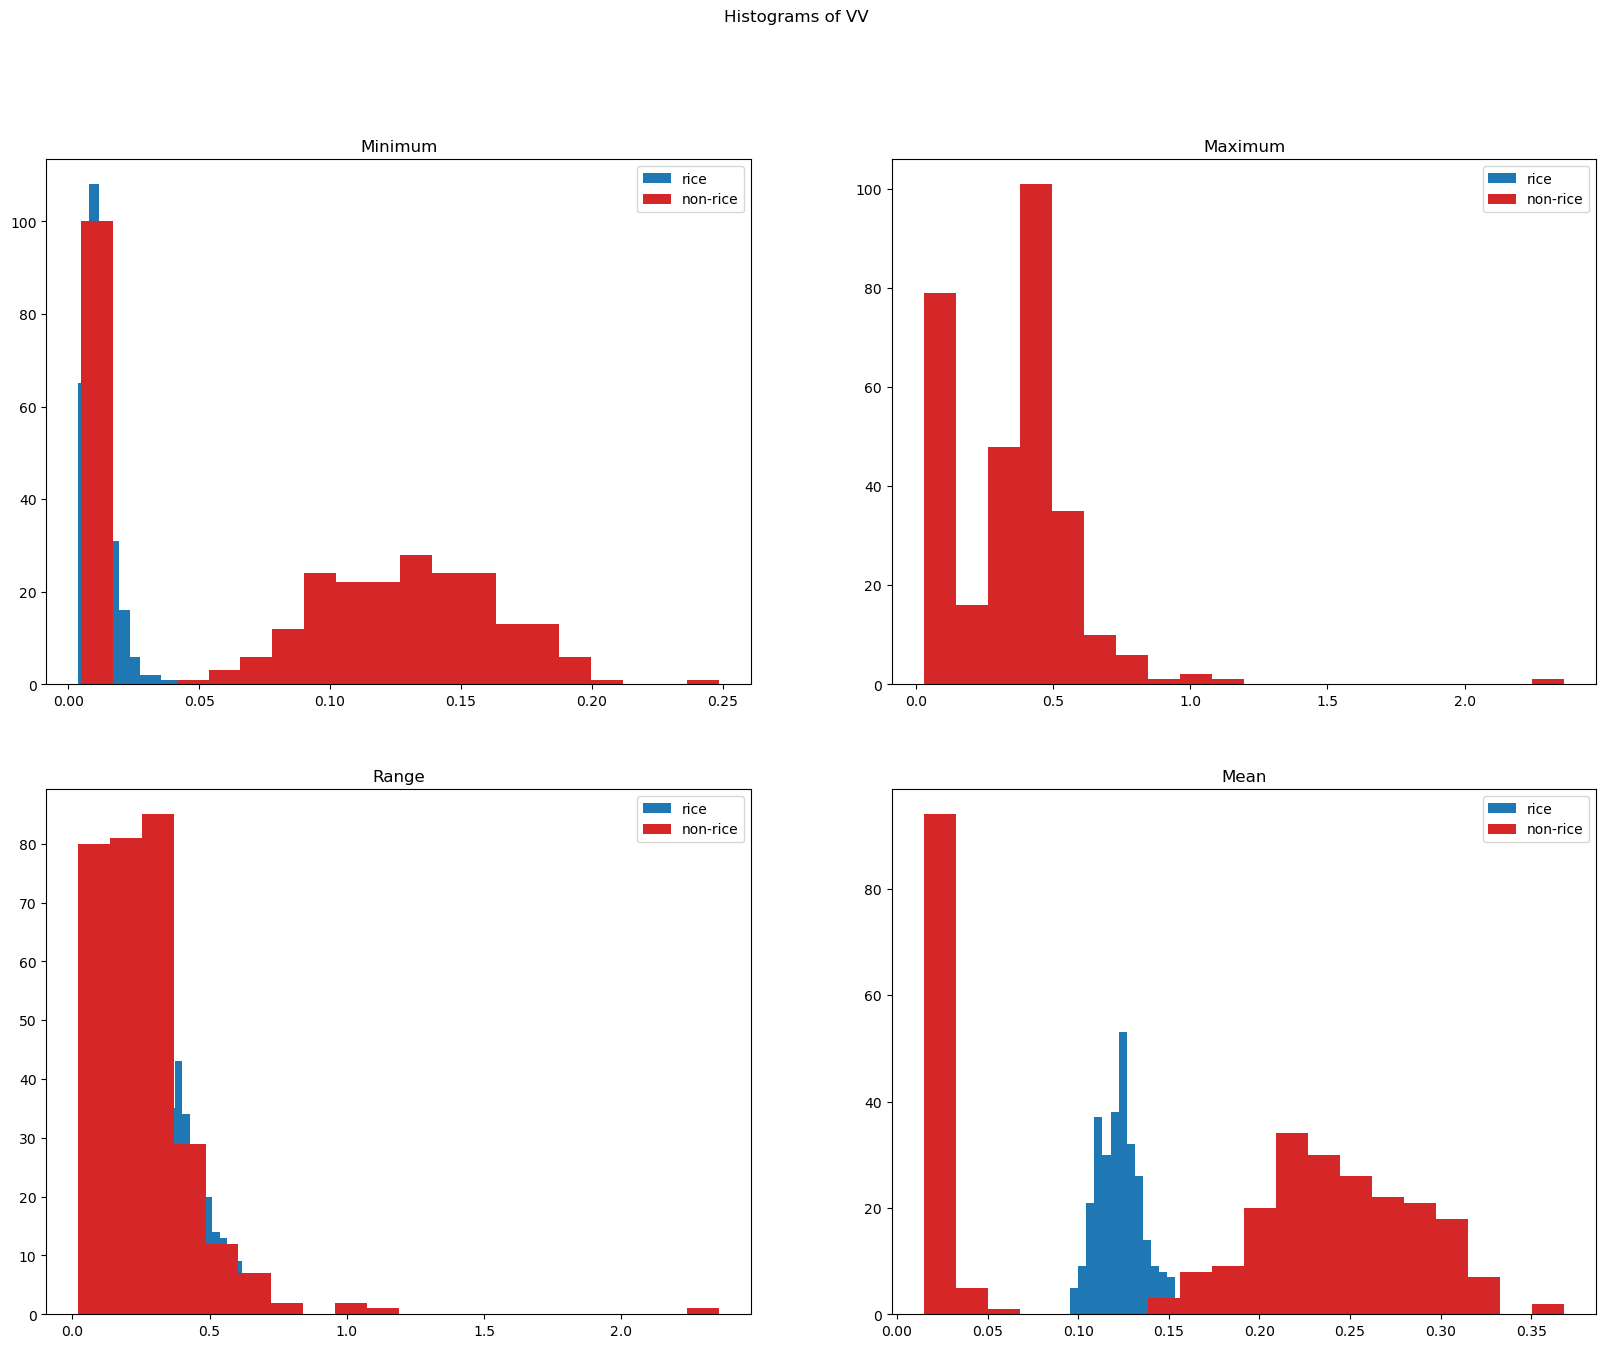

In [9]:
# Histogram plots for vv
n_bins = 20
fig, axs = plt.subplots(2, 2, figsize = (20,15))

axs[0, 0].hist(crop_data_final["min_vv"][:300], bins=n_bins, label = "rice", color = "tab:blue")
axs[0, 0].hist(crop_data_final["min_vv"][300:], bins=n_bins, label = "non-rice", color = "tab:red")
axs[0, 0].set(title = "Minimum") 
axs[0, 0].legend(loc='upper right')

axs[0, 1].hist(crop_data_final["max_vv"][:300], bins=n_bins, label = "rice", color = "tab:blue")
axs[0, 1].hist(crop_data_final["max_vv"][300:], bins=n_bins, label = "non-rice", color = "tab:red")
axs[0, 1].set(title = "Maximum") 
axs[0, 1].legend(loc='upper right')

axs[1, 0].hist(crop_data_final["range_vv"][:300], bins=n_bins, label = "rice", color = "tab:blue")
axs[1, 0].hist(crop_data_final["range_vv"][300:], bins=n_bins, label = "non-rice", color = "tab:red")
axs[1, 0].set(title = "Range") 
axs[1, 0].legend(loc='upper right')

axs[1, 1].hist(crop_data_final["mean_vv"][:300], bins=n_bins, label = "rice", color = "tab:blue")
axs[1, 1].hist(crop_data_final["mean_vv"][300:], bins=n_bins, label = "non-rice", color = "tab:red")
axs[1, 1].set(title = "Mean") 
axs[1, 1].legend(loc='upper right')

plt.suptitle("Histograms of VV")
plt.show()

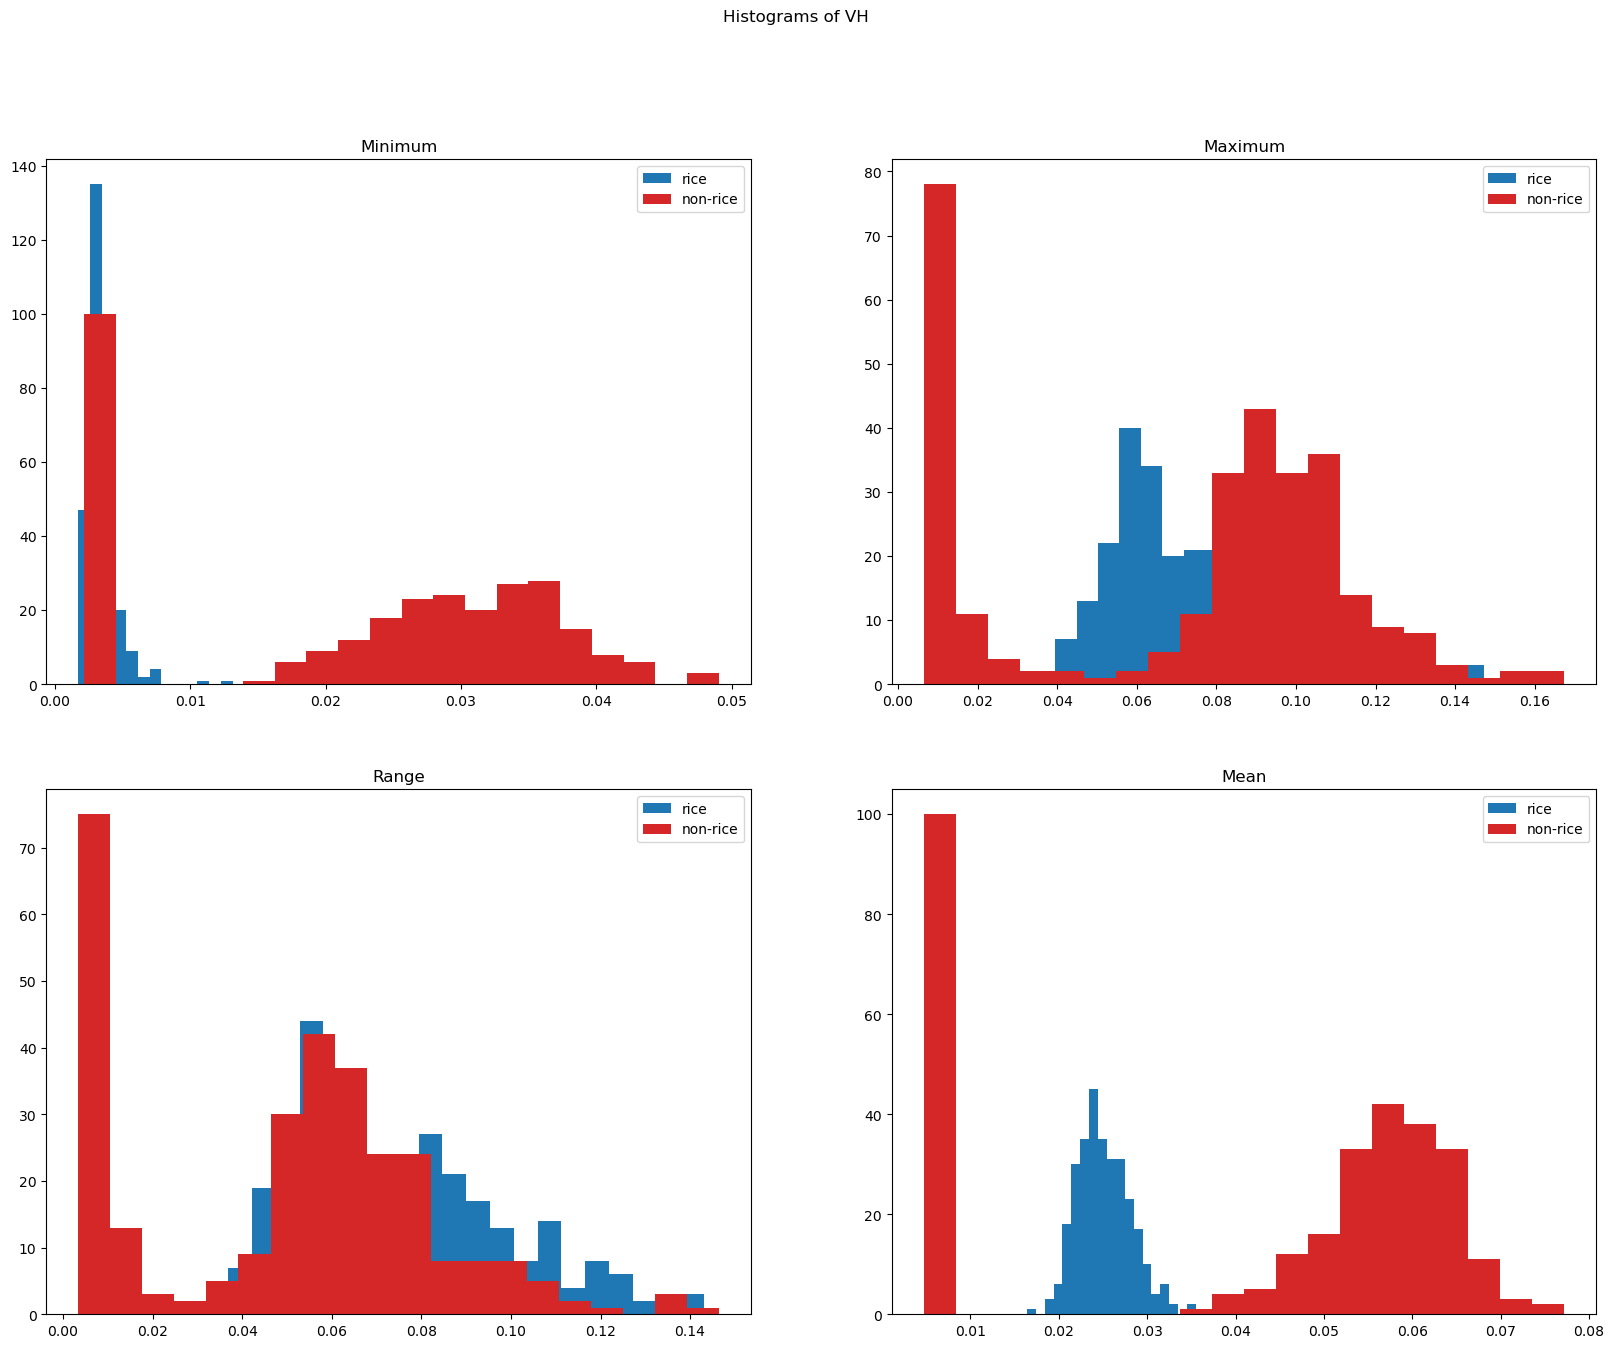

In [10]:
# Histogram plots for vh
n_bins = 20
fig, axs = plt.subplots(2, 2, figsize = (20,15))

axs[0, 0].hist(crop_data_final["min_vh"][:300], bins=n_bins, label = "rice", color = "tab:blue")
axs[0, 0].hist(crop_data_final["min_vh"][300:], bins=n_bins, label = "non-rice", color = "tab:red")
axs[0, 0].set(title = "Minimum") 
axs[0, 0].legend(loc='upper right')

axs[0, 1].hist(crop_data_final["max_vh"][:300], bins=n_bins, label = "rice", color = "tab:blue")
axs[0, 1].hist(crop_data_final["max_vh"][300:], bins=n_bins, label = "non-rice", color = "tab:red")
axs[0, 1].set(title = "Maximum") 
axs[0, 1].legend(loc='upper right')

axs[1, 0].hist(crop_data_final["range_vh"][:300], bins=n_bins, label = "rice", color = "tab:blue")
axs[1, 0].hist(crop_data_final["range_vh"][300:], bins=n_bins, label = "non-rice", color = "tab:red")
axs[1, 0].set(title = "Range") 
axs[1, 0].legend(loc='upper right')

axs[1, 1].hist(crop_data_final["mean_vh"][:300], bins=n_bins, label = "rice", color = "tab:blue")
axs[1, 1].hist(crop_data_final["mean_vh"][300:], bins=n_bins, label = "non-rice", color = "tab:red")
axs[1, 1].set(title = "Mean") 
axs[1, 1].legend(loc='upper right')

plt.suptitle("Histograms of VH")
plt.show()

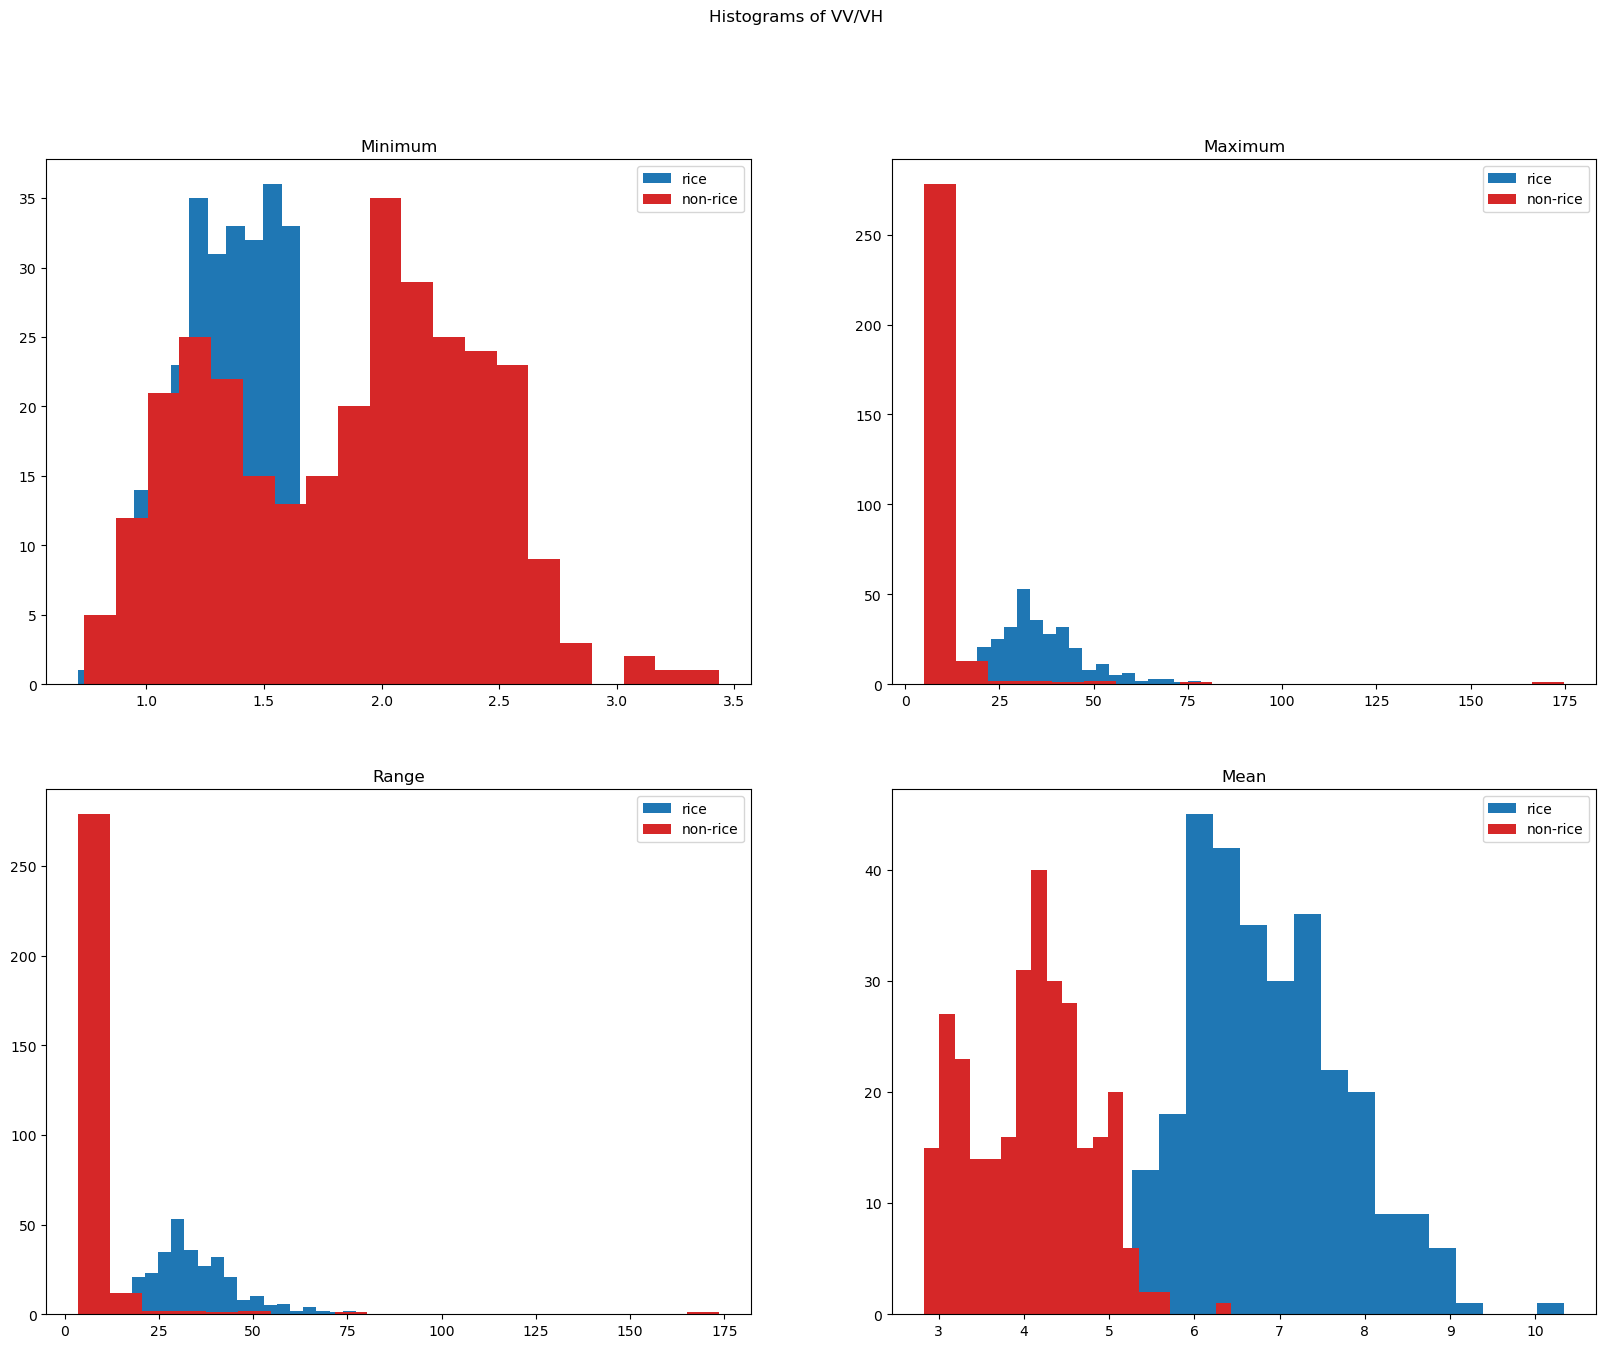

In [11]:
# Histogram plots for vv_vh
n_bins = 20
fig, axs = plt.subplots(2, 2, figsize = (20,15))

axs[0, 0].hist(crop_data_final["min_vv_by_vh"][:300], bins=n_bins, label = "rice", color = "tab:blue")
axs[0, 0].hist(crop_data_final["min_vv_by_vh"][300:], bins=n_bins, label = "non-rice", color = "tab:red")
axs[0, 0].set(title = "Minimum") 
axs[0, 0].legend(loc='upper right')

axs[0, 1].hist(crop_data_final["max_vv_by_vh"][:300], bins=n_bins, label = "rice", color = "tab:blue")
axs[0, 1].hist(crop_data_final["max_vv_by_vh"][300:], bins=n_bins, label = "non-rice", color = "tab:red")
axs[0, 1].set(title = "Maximum") 
axs[0, 1].legend(loc='upper right')

axs[1, 0].hist(crop_data_final["range_vv_by_vh"][:300], bins=n_bins, label = "rice", color = "tab:blue")
axs[1, 0].hist(crop_data_final["range_vv_by_vh"][300:], bins=n_bins, label = "non-rice", color = "tab:red")
axs[1, 0].set(title = "Range") 
axs[1, 0].legend(loc='upper right')

axs[1, 1].hist(crop_data_final["mean_vv_by_vh"][:300], bins=n_bins, label = "rice", color = "tab:blue")
axs[1, 1].hist(crop_data_final["mean_vv_by_vh"][300:], bins=n_bins, label = "non-rice", color = "tab:red")
axs[1, 1].set(title = "Mean") 
axs[1, 1].legend(loc='upper right')

plt.suptitle("Histograms of VV/VH")
plt.show()

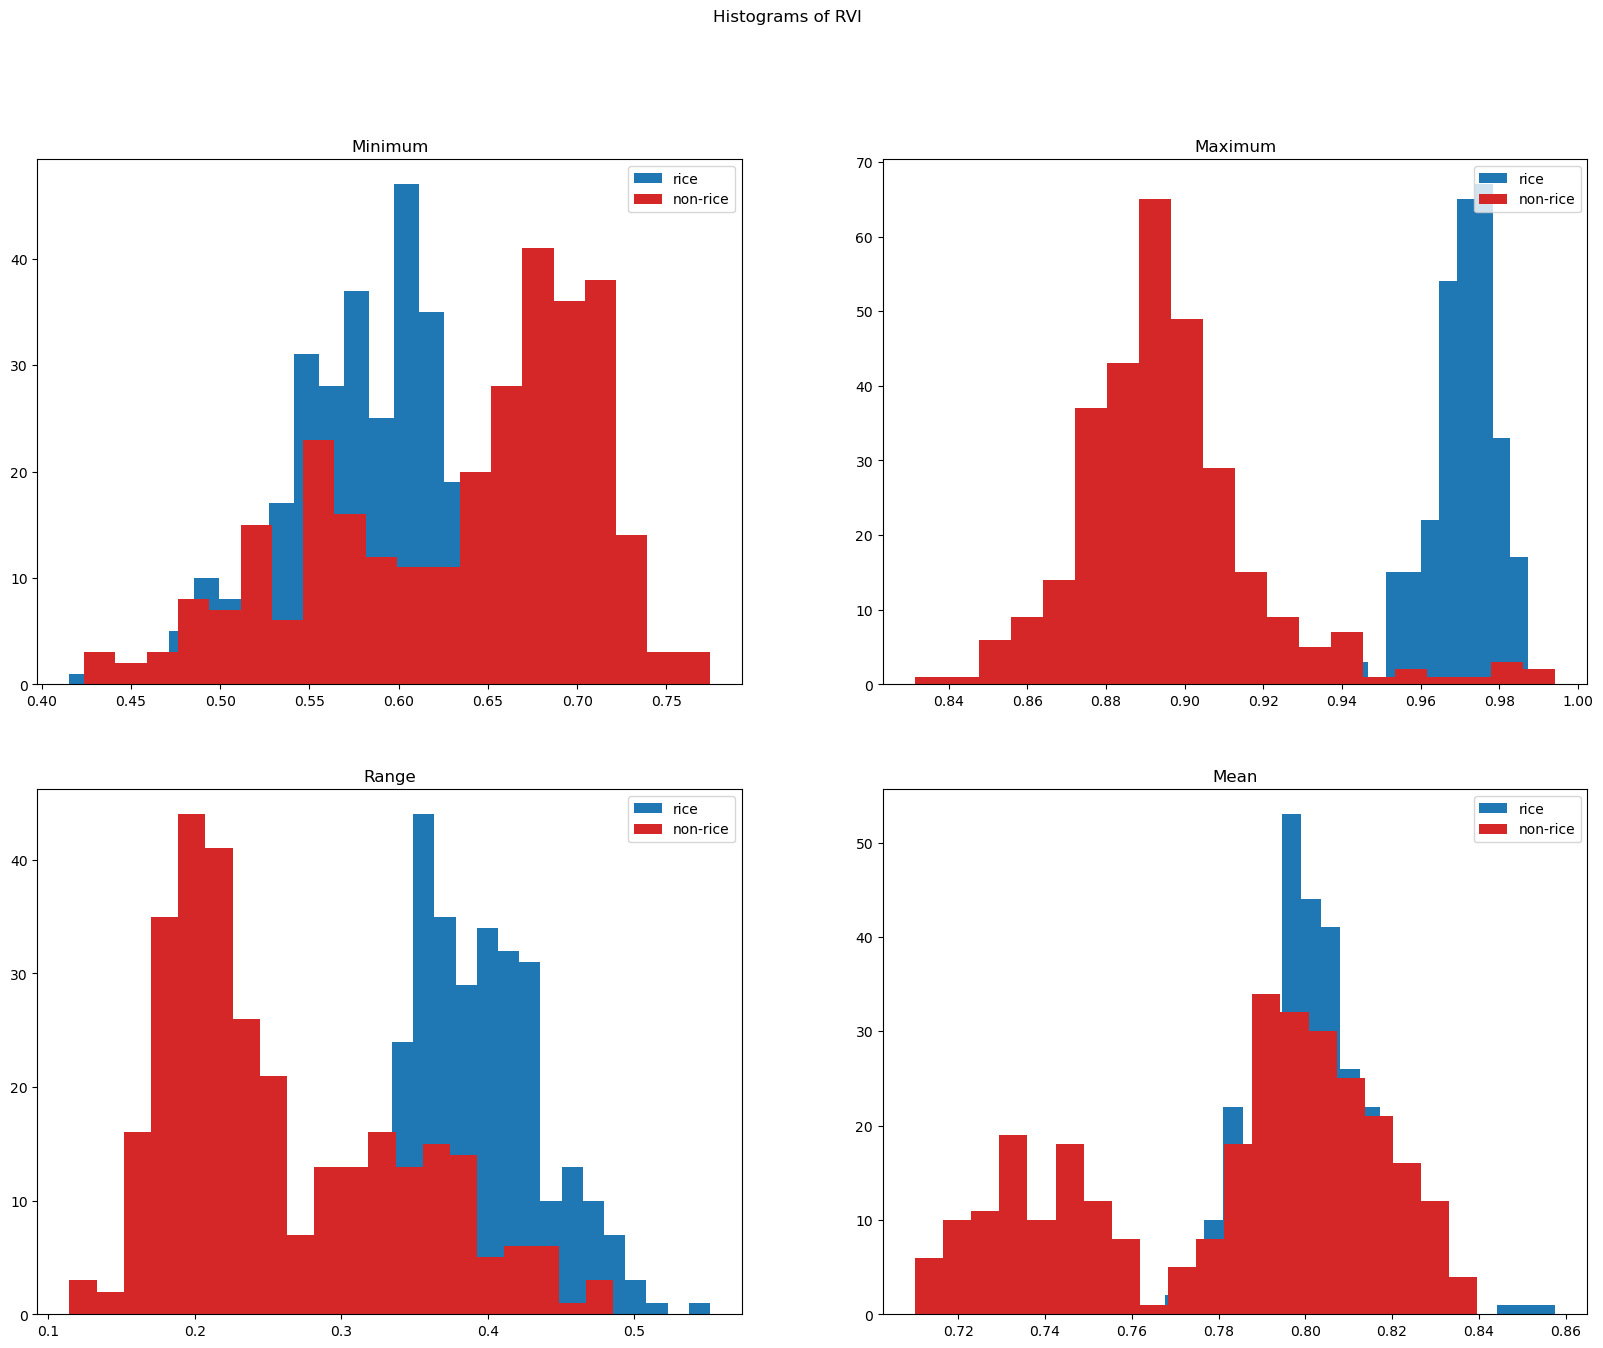

In [12]:
# Histogram plots for rvi
n_bins = 20
fig, axs = plt.subplots(2, 2, figsize = (20,15))

axs[0, 0].hist(crop_data_final["min_rvi"][:300], bins=n_bins, label = "rice", color = "tab:blue")
axs[0, 0].hist(crop_data_final["min_rvi"][300:], bins=n_bins, label = "non-rice", color = "tab:red")
axs[0, 0].set(title = "Minimum") 
axs[0, 0].legend(loc='upper right')

axs[0, 1].hist(crop_data_final["max_rvi"][:300], bins=n_bins, label = "rice", color = "tab:blue")
axs[0, 1].hist(crop_data_final["max_rvi"][300:], bins=n_bins, label = "non-rice", color = "tab:red")
axs[0, 1].set(title = "Maximum") 
axs[0, 1].legend(loc='upper right')

axs[1, 0].hist(crop_data_final["range_rvi"][:300], bins=n_bins, label = "rice", color = "tab:blue")
axs[1, 0].hist(crop_data_final["range_rvi"][300:], bins=n_bins, label = "non-rice", color = "tab:red")
axs[1, 0].set(title = "Range") 
axs[1, 0].legend(loc='upper right')

axs[1, 1].hist(crop_data_final["mean_rvi"][:300], bins=n_bins, label = "rice", color = "tab:blue")
axs[1, 1].hist(crop_data_final["mean_rvi"][300:], bins=n_bins, label = "non-rice", color = "tab:red")
axs[1, 1].set(title = "Mean") 
axs[1, 1].legend(loc='upper right')

plt.suptitle("Histograms of RVI")
plt.show()

In [13]:
crop_data_final.describe()

,min_vv,max_vv,range_vv,mean_vv,min_vh,max_vh,range_vh,mean_vh,min_vv_by_vh,max_vv_by_vh,range_vv_by_vh,mean_vv_by_vh,min_rvi,max_rvi,range_rvi,mean_rvi
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,0.051225,0.387562,0.336337,0.147177,0.012618,0.074903,0.062285,0.032696,1.630613,22.924733,21.294120,5.428760,0.607368,0.932612,0.325245,0.791747
std,0.059832,0.188393,0.184405,0.083570,0.013522,0.034965,0.030834,0.019547,0.488984,17.295652,17.497618,1.590091,0.068747,0.041362,0.092925,0.027341
min,0.003896,0.029297,0.021753,0.014748,0.001731,0.006505,0.003419,0.004726,0.710828,4.932840,3.643859,2.825229,0.415488,0.831447,0.114430,0.709994
25%,0.007964,0.330177,0.248252,0.110536,0.003069,0.057207,0.049463,0.022243,1.257388,8.446122,6.374926,4.126665,0.557010,0.894136,0.234804,0.785014
50%,0.013214,0.404597,0.344461,0.127159,0.003684,0.081842,0.062593,0.026259,1.524916,17.444683,16.158351,5.178125,0.603947,0.945779,0.349472,0.797525
75%,0.104092,0.475000,0.428733,0.215759,0.025718,0.099704,0.080763,0.053225,1.968192,34.252301,32.855993,6.690833,0.663095,0.971633,0.395644,0.808500
max,0.248402,2.363277,2.355309,0.368260,0.049050,0.167438,0.146424,0.077209,3.433920,174.838739,173.507182,10.340100,0.774466,0.994313,0.551634,0.857659


### Data Preparation

In [14]:
# Select X and Y
X = crop_data_final.iloc[..., 2:]
Y = crop_data_final.iloc[..., 1]

In [15]:
X.describe()

,min_vv,max_vv,range_vv,mean_vv,min_vh,max_vh,range_vh,mean_vh,min_vv_by_vh,max_vv_by_vh,range_vv_by_vh,mean_vv_by_vh,min_rvi,max_rvi,range_rvi,mean_rvi
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,0.051225,0.387562,0.336337,0.147177,0.012618,0.074903,0.062285,0.032696,1.630613,22.924733,21.294120,5.428760,0.607368,0.932612,0.325245,0.791747
std,0.059832,0.188393,0.184405,0.083570,0.013522,0.034965,0.030834,0.019547,0.488984,17.295652,17.497618,1.590091,0.068747,0.041362,0.092925,0.027341
min,0.003896,0.029297,0.021753,0.014748,0.001731,0.006505,0.003419,0.004726,0.710828,4.932840,3.643859,2.825229,0.415488,0.831447,0.114430,0.709994
25%,0.007964,0.330177,0.248252,0.110536,0.003069,0.057207,0.049463,0.022243,1.257388,8.446122,6.374926,4.126665,0.557010,0.894136,0.234804,0.785014
50%,0.013214,0.404597,0.344461,0.127159,0.003684,0.081842,0.062593,0.026259,1.524916,17.444683,16.158351,5.178125,0.603947,0.945779,0.349472,0.797525
75%,0.104092,0.475000,0.428733,0.215759,0.025718,0.099704,0.080763,0.053225,1.968192,34.252301,32.855993,6.690833,0.663095,0.971633,0.395644,0.808500
max,0.248402,2.363277,2.355309,0.368260,0.049050,0.167438,0.146424,0.077209,3.433920,174.838739,173.507182,10.340100,0.774466,0.994313,0.551634,0.857659


In [16]:
X.dtypes

min_vv            float64
max_vv            float64
range_vv          float64
mean_vv           float64
min_vh            float64
max_vh            float64
range_vh          float64
mean_vh           float64
min_vv_by_vh      float64
max_vv_by_vh      float64
range_vv_by_vh    float64
mean_vv_by_vh     float64
min_rvi           float64
max_rvi           float64
range_rvi         float64
mean_rvi          float64
dtype: object

In [17]:
Y

0          Rice
1          Rice
2          Rice
3          Rice
4          Rice
         ...   
595    Non Rice
596    Non Rice
597    Non Rice
598    Non Rice
599    Non Rice
Name: Class of Land, Length: 600, dtype: object

In [18]:
Y = np.where(Y == "Rice", 1, 0)

In [19]:
class_names = ["Non Rice", "Rice"]
Y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,

In [20]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 123)

# Check dimensions 
print(f"Shape of x train: {x_train.shape}") 
print(f"Shape of x test: {x_test .shape}") 
print(f"Shape of y train: {y_train.shape}") 
print(f"Shape of y test: {y_test.shape}")

Shape of x train: (480, 16)
Shape of x test: (120, 16)
Shape of y train: (480,)
Shape of y test: (120,)


## Model Creation

In [42]:
# !pip install tensorflow

In [43]:
import tensorflow as tf
from tensorflow import keras

In [44]:
# Clear any previous models 
keras.backend.clear_session() 
# keras.layers.Dropout(rate=.2), kernel_initializer = "he_normal" 
# Initialize MLP model 
mlp = keras.models.Sequential([keras.layers.Flatten(input_shape = [16, 1]), 
                               keras.layers.Dense(256, activation = "relu", kernel_initializer = "he_normal"), 
                               keras.layers.Dropout(rate=.2), 
                               keras.layers.Dense(128, activation = "relu", kernel_initializer = "he_normal"), 
                               keras.layers.Dropout(rate = .1), 
                               keras.layers.Dense(1, activation = "sigmoid")]) 
# Compile the model 
mlp.compile(loss = keras.losses.binary_crossentropy, optimizer = keras.optimizers.Adam(), metrics = ['accuracy' ,keras.metrics.Precision()]) 

mlp.summary ()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 256)               4352      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 37,377
Trainable params: 37,377
Non-traina

### Training Set Evaluation

In [45]:
# Fit model with training data and get history to plot 
# Set seed for replicability 
tf.random.set_seed(123) 
# Fit mlp with a 70-30 split 
mlp_hist = mlp.fit(x_train, y_train, validation_split = 0.3, epochs = 100, verbose = 2)

Epoch 1/100
11/11 - 2s - loss: 1.1587 - accuracy: 0.6875 - precision: 0.6513 - val_loss: 1.7642 - val_accuracy: 0.8056 - val_precision: 0.6923 - 2s/epoch - 161ms/step
Epoch 2/100
11/11 - 0s - loss: 0.7197 - accuracy: 0.8363 - precision: 0.8389 - val_loss: 1.9917 - val_accuracy: 0.8819 - val_precision: 0.7875 - 70ms/epoch - 6ms/step
Epoch 3/100
11/11 - 0s - loss: 0.5289 - accuracy: 0.8690 - precision: 0.8276 - val_loss: 1.1478 - val_accuracy: 0.9583 - val_precision: 0.9385 - 79ms/epoch - 7ms/step
Epoch 4/100
11/11 - 0s - loss: 0.4670 - accuracy: 0.9077 - precision: 0.9244 - val_loss: 2.0722 - val_accuracy: 0.8889 - val_precision: 0.7975 - 72ms/epoch - 7ms/step
Epoch 5/100
11/11 - 0s - loss: 0.4878 - accuracy: 0.9167 - precision: 0.8984 - val_loss: 1.0832 - val_accuracy: 0.9583 - val_precision: 0.9385 - 75ms/epoch - 7ms/step
Epoch 6/100
11/11 - 0s - loss: 0.5785 - accuracy: 0.9256 - precision: 0.9270 - val_loss: 1.0679 - val_accuracy: 0.9653 - val_precision: 0.9394 - 85ms/epoch - 8ms/ste

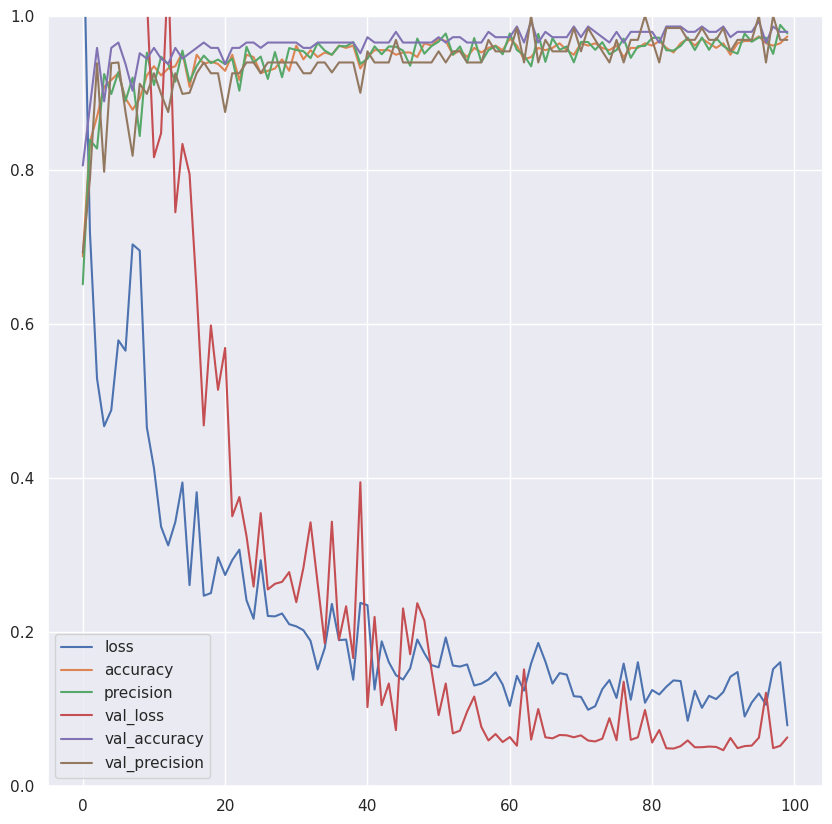

In [47]:
# Plot history
pd.DataFrame(mlp_hist.history).plot()
plt.grid(True)
plt.gca().set_ylim(0.0, 1.0)
plt.show()

### Validation Set Evaluation

In [48]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [49]:
mlp.evaluate(x_test, y_test)

4/4 [==============================] - 0s 3ms/step - loss: 0.1033 - accuracy: 0.9583 - precision: 0.9231


[0.10334441065788269, 0.9583333134651184, 0.9230769276618958]

In [50]:
# Plot results
pred_vals = np.concatenate(mlp.predict(x_test).round(), axis = 0).astype(int)
pred_vals

4/4 [==============================] - 0s 2ms/step


array([0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 0])

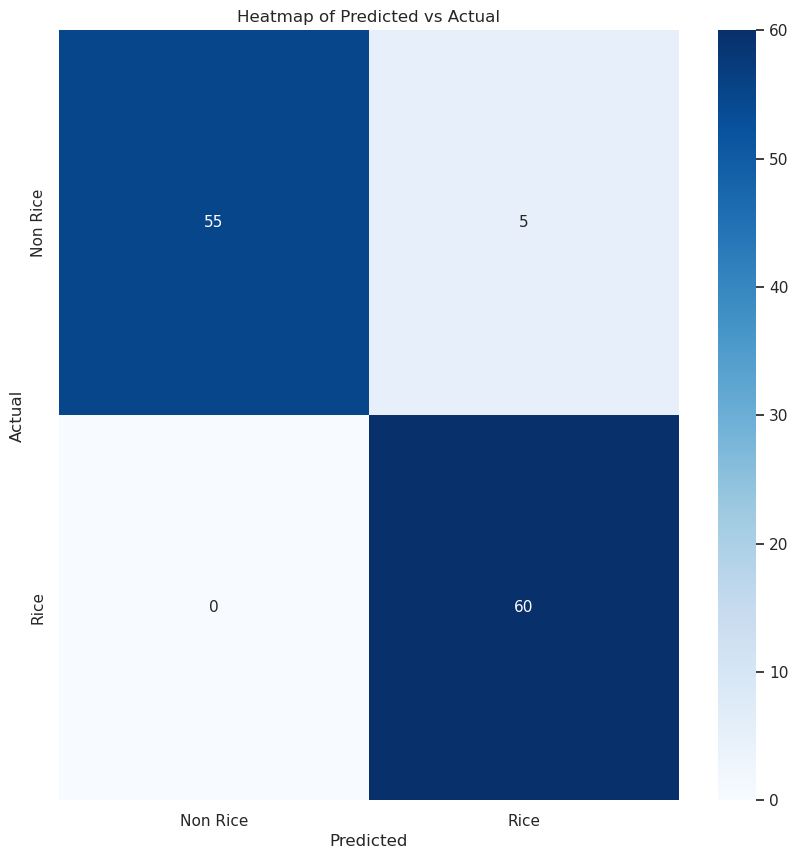

In [51]:
cm = confusion_matrix(y_test, pred_vals)
df_cm = pd.DataFrame(cm, columns = class_names, index = class_names)
df_cm.index.name = "Actual"
df_cm.columns.name = "Predicted"

sns.set(font_scale = 0.9)
sns.set(rc={"figure.figsize": (10, 10)})
sns.heatmap(df_cm, cmap = "Blues", annot = True, annot_kws = {"size": 11}, fmt='g').set(title = "Heatmap of Predicted vs Actual")
plt.show()

In [52]:
# Classification report
print("Classification Report on Test Set")
print(classification_report(y_test, pred_vals, target_names = class_names))

Classification Report on Test Set
              precision    recall  f1-score   support

    Non Rice       1.00      0.92      0.96        60
        Rice       0.92      1.00      0.96        60

    accuracy                           0.96       120
   macro avg       0.96      0.96      0.96       120
weighted avg       0.96      0.96      0.96       120



## Challenge Set 

In [53]:
challenge = pd.read_csv("challenge_1_submission_template_correct_columns_fixed.csv")
challenge

,id,target
0,"(10.18019073690894, 105.32022315786804)",NaN
1,"(10.561107033461816, 105.12772097986661)",NaN
2,"(10.623790611954897, 105.13771401411867)",NaN
3,"(10.583364246115156, 105.23946127195805)",NaN
4,"(10.20744446668854, 105.26844107128906)",NaN
...,...,...
245,"(10.308283266873062, 105.50872812216863)",NaN
246,"(10.582910017285496, 105.23991550078767)",NaN
247,"(10.581547330796518, 105.23991550078767)",NaN
248,"(10.629241357910818, 105.15315779432643)",NaN


In [54]:
train_band_values=challenge.progress_apply(lambda x: get_sentinel_data(x["id"]), axis=1)
vh = [x[0] for x in train_band_values]
vv = [x[1] for x in train_band_values]
vv_by_vh = [x[2] for x in train_band_values]
vh_vv_data = pd.DataFrame(list(zip(vh,vv,vv_by_vh)),columns = ["vv_list","vh_list","vv/vh_list"])

100%|██████████| 250/250 [48:32<00:00, 11.65s/it]


In [55]:
for col in vh_vv_data.columns:
    vh_vv_data[col] = vh_vv_data[col].apply(lambda x: np.array(x))

In [56]:
rvi = (vh_vv_data["vv_list"] / (vh_vv_data["vv_list"] + vh_vv_data["vh_list"]))
rvi

0      [0.6934660316485579, 0.5475368882842185, 0.700...
1      [0.8627907653862491, 0.7926160181292811, 0.834...
2      [0.9643852217834891, 0.948557126296569, 0.8718...
3      [0.6553383569142758, 0.7794217710843198, 0.800...
4      [0.7061504258271251, 0.7220776450247584, 0.871...
                             ...                        
245    [0.6372886073808575, 0.6730416311342043, 0.766...
246    [0.7325926589532095, 0.8466471567453002, 0.845...
247    [0.6716225045804242, 0.8010827535161774, 0.765...
248    [0.9879620103625607, 0.9786252689524993, 0.934...
249    [0.8436008759317494, 0.6524801716814794, 0.681...
Length: 250, dtype: object

In [57]:
vh_vv_data["rvi"] = rvi
vh_vv_data

,vv_list,vh_list,vv/vh_list,rvi
0,"[0.010586533695459366, 0.008605285547673702, 0...","[0.004679583478718996, 0.007111072074621916, 0...","[2.2622811931025444, 1.2101249231299953, 2.339...","[0.6934660316485579, 0.5475368882842185, 0.700..."
1,"[0.009555697441101074, 0.010459705255925655, 0...","[0.0015196383465081453, 0.0027367291040718555,...","[6.288139189866024, 3.8219731870294114, 5.0551...","[0.8627907653862491, 0.7926160181292811, 0.834..."
2,"[0.11977537721395493, 0.07649119198322296, 0.0...","[0.004423308651894331, 0.004148328676819801, 0...","[27.078231848609477, 18.439038451953802, 6.802...","[0.9643852217834891, 0.948557126296569, 0.8718..."
3,"[0.007301058620214462, 0.013919728808104992, 0...","[0.0038398406468331814, 0.0039393166080117226,...","[1.9013962535752205, 3.533538984857236, 4.0222...","[0.6553383569142758, 0.7794217710843198, 0.800..."
4,"[0.009329406078904867, 0.008071513380855322, 0...","[0.003882235148921609, 0.0031066659139469266, ...","[2.403101749644493, 2.5981272542436673, 6.7950...","[0.7061504258271251, 0.7220776450247584, 0.871..."
...,...,...,...,...
245,"[0.00872089434415102, 0.012391516007483006, 0....","[0.004963477607816458, 0.006019701715558767, 0...","[1.757012931904317, 2.058493359472511, 3.28009...","[0.6372886073808575, 0.6730416311342043, 0.766..."
246,"[0.008095650933682919, 0.01522239949554205, 0....","[0.002955034375190735, 0.0027572268154472113, ...","[2.739613116399155, 5.520909418934777, 5.45269...","[0.7325926589532095, 0.8466471567453002, 0.845..."
247,"[0.009455842897295952, 0.012584727257490158, 0...","[0.00462326081469655, 0.003124919719994068, 0....","[2.0452756779884567, 4.027216179977272, 3.2614...","[0.6716225045804242, 0.8010827535161774, 0.765..."
248,"[0.2817420959472656, 0.2392944097518921, 0.164...","[0.0034329340560361743, 0.005226570181548595, ...","[82.07034896341067, 45.7842143967903, 14.33527...","[0.9879620103625607, 0.9786252689524993, 0.934..."


In [59]:
features = generate_stastical_features(vh_vv_data)
challenge_data_final = pd.DataFrame(features ,columns = ['min_vv', 'max_vv', 'range_vv', 'mean_vv', 'min_vh', 'max_vh', 'range_vh', 'mean_vh', 
                          'min_vv_by_vh',  'max_vv_by_vh', 'range_vv_by_vh', 'mean_vv_by_vh', 'min_rvi', 'max_rvi', 'range_rvi', 'mean_rvi'])

challenge_data_final

,min_vv,max_vv,range_vv,mean_vv,min_vh,max_vh,range_vh,mean_vh,min_vv_by_vh,max_vv_by_vh,range_vv_by_vh,mean_vv_by_vh,min_rvi,max_rvi,range_rvi,mean_rvi
0,0.007284,0.422283,0.414999,0.091416,0.002965,0.073937,0.070972,0.018676,1.175154,16.886364,15.711210,5.671990,0.540262,0.944091,0.403829,0.785838
1,0.006580,0.281788,0.275208,0.085067,0.001520,0.073306,0.071786,0.020657,1.711388,23.607419,21.896031,4.935240,0.631185,0.959362,0.328177,0.784524
2,0.020353,0.300508,0.280156,0.120844,0.002518,0.094339,0.091820,0.021423,1.479806,27.078232,25.598426,8.396460,0.596743,0.964385,0.367643,0.843095
3,0.006193,0.112329,0.106137,0.016201,0.002629,0.022532,0.019903,0.004483,1.326080,9.755626,8.429546,3.575118,0.570092,0.907025,0.336933,0.763780
4,0.005279,0.301543,0.296264,0.100702,0.002547,0.052177,0.049631,0.017986,1.243472,35.334473,34.091001,6.687759,0.554262,0.972478,0.418216,0.810358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.008685,0.127352,0.118667,0.017930,0.003380,0.013583,0.010203,0.005466,1.290042,9.375549,8.085507,3.221156,0.563327,0.903620,0.340293,0.736165
246,0.006412,0.197399,0.190986,0.018214,0.002365,0.042182,0.039816,0.004737,1.357034,9.012309,7.655276,3.722779,0.575738,0.900123,0.324385,0.771778
247,0.008257,0.129412,0.121154,0.018787,0.002384,0.017801,0.015417,0.004862,1.497867,12.326875,10.829008,3.490126,0.599658,0.924964,0.325305,0.756108
248,0.008001,0.371705,0.363704,0.125352,0.003101,0.067941,0.064840,0.020231,1.885698,82.070349,80.184651,11.274474,0.653463,0.987962,0.334499,0.835796


In [60]:
# Get Challenge Values
challenge_vals = np.concatenate(mlp.predict(challenge_data_final).round(), axis = 0).astype(int)
challenge_vals

8/8 [==============================] - 0s 2ms/step


array([1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1])

In [61]:
target = np.where(challenge_vals == 1, "Rice", "Non Rice")
target

array(['Rice', 'Rice', 'Rice', 'Non Rice', 'Rice', 'Non Rice', 'Non Rice',
       'Rice', 'Non Rice', 'Rice', 'Non Rice', 'Rice', 'Rice', 'Non Rice',
       'Non Rice', 'Non Rice', 'Rice', 'Non Rice', 'Non Rice', 'Rice',
       'Rice', 'Non Rice', 'Rice', 'Non Rice', 'Rice', 'Rice', 'Rice',
       'Non Rice', 'Non Rice', 'Rice', 'Non Rice', 'Rice', 'Rice', 'Rice',
       'Rice', 'Non Rice', 'Non Rice', 'Non Rice', 'Non Rice', 'Rice',
       'Rice', 'Non Rice', 'Non Rice', 'Rice', 'Rice', 'Non Rice', 'Rice',
       'Rice', 'Rice', 'Rice', 'Non Rice', 'Non Rice', 'Non Rice',
       'Non Rice', 'Non Rice', 'Non Rice', 'Rice', 'Rice', 'Non Rice',
       'Non Rice', 'Rice', 'Rice', 'Rice', 'Non Rice', 'Non Rice',
       'Non Rice', 'Non Rice', 'Rice', 'Non Rice', 'Non Rice', 'Rice',
       'Non Rice', 'Non Rice', 'Rice', 'Non Rice', 'Non Rice', 'Rice',
       'Rice', 'Non Rice', 'Non Rice', 'Non Rice', 'Non Rice', 'Non Rice',
       'Non Rice', 'Rice', 'Rice', 'Non Rice', 'Non Rice', 'Non R

In [62]:
challenge["target"] = target
challenge

,id,target
0,"(10.18019073690894, 105.32022315786804)",Rice
1,"(10.561107033461816, 105.12772097986661)",Rice
2,"(10.623790611954897, 105.13771401411867)",Rice
3,"(10.583364246115156, 105.23946127195805)",Non Rice
4,"(10.20744446668854, 105.26844107128906)",Rice
...,...,...
245,"(10.308283266873062, 105.50872812216863)",Non Rice
246,"(10.582910017285496, 105.23991550078767)",Non Rice
247,"(10.581547330796518, 105.23991550078767)",Non Rice
248,"(10.629241357910818, 105.15315779432643)",Rice


In [63]:
challenge.to_csv("level_1_final_submission.csv",index = False)